In [149]:
from aslearn import *
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns
import time


X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Overview:
The goal of this project is to create a fully featured production quality machine learning library that has support for multiple machine learning models.
While there are multiple libraries already available, building one from the ground up will help me learn how the models work under the hood, and put into practice object orientated methodologies.

This workbook is mainly to test the functionality the library.

**aslearn** is the name of my toy ML library.  It is named aslearn in homage to scikit-learn (sklearn) replacing “sk” with my initials “as”-- very creative I know. As the name might suggest, aslearn been developed to function with a similar API to scikit-learn, with a few extra features that I thought would be interesting.  I have not looked at the scikit-learn source code or documentation for reference and have reversed engendered its functionality solely from memory, so some things may be a bit different.  Because aslearn is implemented completely in python using only the numpy library.  I have vectorized the math as much as I could with numpy to keep performance reasonable, but the main goal of the project is not bleeding edge performance.

# Glossary
This implementation has some built in functionality that can be accessed through the key word arguments.  Some of these functions are not available in other libraries so their use may not be intuitive at first.

**PCA Kwarg Features:**
- **features:** The amount of features to keep.  When a value greater than one is entered, PCA will find the eigenvectors that contain the most variance and order them from greatest variance to least.  The top N features will be selected that retain the greatest variance.  When a value less than one is entered PCA will automatically select the amount of features to keep that retain the variance specified.
- **feature_scaling:** There is a built in feature scaling class which is accessible through a fit and transformed in the Utils class, the PCA Class has access to this.  When set to True, the training data is automatically scaled before being passed through.  The fitted scaler class is stored in the classifier and when the predict method is called, the input is automatically scaled using the stored values learned during training.  I find this method simplifies the processing pipeline.

**K-Means Kwarg Features:**

- **K:** The number of centroids to cluster around
- **epochs:** The amount of times the full dataset will be iterated over during training
- **batch_size:** The size of each set of training data that will be used to minimize J in relation to theta

**Terms:**

In this workbook I may refer to some terms by the Greek symbols that are used to notate them in the mathematical equations.
- **X:**  The matrix that holds the vectors of the training samples
- **Class, Target, Label:** Used somewhat interchangeable.  These are the distinct values found in y
- **Features:**  The amount of columns for the data.  Also called dimensions

# Methodology:
For the remainder of this workbook, I will work through solving the MNIST problem using PCA and K-Means clustering to showcase the functionality of the aslearn library, as well as the thought process for tackling this kind of problem.

# MNIST Dataset:
**MNIST** is a dataset of hand drawn numbers between Zero and Nine, as well as the labels for those digits.  It has been referred to as the "Hello World" of machine learning.  Because it is such a common dataset, it is a great place to start to make sure that the library is functioning correctly.



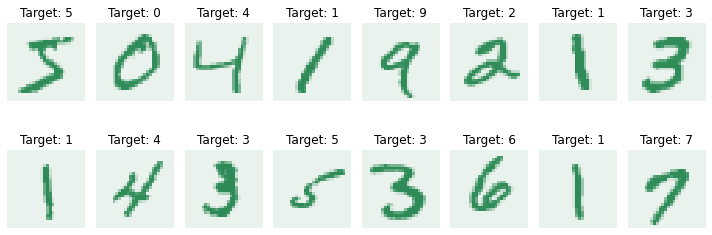

In [3]:
rows = 2
columns = 8
fig, axs = plt.subplots(rows,columns, figsize=(10, 4))
indx = 0
for i in range(rows):
    for j in range(columns):
        sample = X[indx]
        axs[i,j].imshow(np.reshape(X[indx], (28,28)), interpolation='nearest', cmap=sns.light_palette("seagreen", as_cmap=True))
        axs[i,j].axis('off')
        axs[i,j].autoscale(False)
        axs[i,j].title.set_text(f'Target: {y[indx]}')
        indx += 1
plt.tight_layout()
plt.show()

The version of MNIST we are using is already broken into X and y for us:

- **X:** The pixel values of the and written numbers.  They are unrolled into a single row vector with values between 0 and 255, representing white intensity.
- **y:** A string value of the class names.  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'

Because we are using unsupervised learning, we will pretend that we do not have labels.  The goal will be to create clusters such that each cluster only keeps on class.

# PCA
Principal Compenent Analysis is an algorythm that can be used to compress the input data so fewer dementions.  In the case of MNIST, many of the pixle values around the edge are empty and do not really contribute to the overall training of the modle.  The extra data points can cause a model to take longer to train.

To see how PCA works we will try reducing our data from 284 dimentions (one for each pixle) down to 25, and then recover it back to the original size.  This will give us a sense of what data is retained after compression.

Reduced to 25 Features:


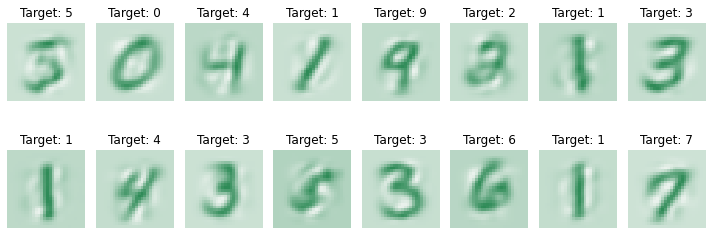

In [143]:
pca = PCA()
features = 25
pca.fit(X, features, feature_scaling=True)
X_tranf = pca.transform(X)
X_restored = pca.reverse_transform(X_tranf)

rows = 2
columns = 8
fig, axs = plt.subplots(rows,columns, figsize=(10, 4))
indx = 0
for i in range(rows):
    for j in range(columns):
        sample = X_restored[indx]
        axs[i,j].imshow(np.reshape(X_restored[indx], (28,28)), interpolation='nearest', cmap=sns.light_palette("seagreen", as_cmap=True))
        axs[i,j].axis('off')
        axs[i,j].autoscale(False)
        axs[i,j].title.set_text(f'Target: {y[indx]}')
        indx += 1
plt.tight_layout()
print(f'Reduced to {pca.k} Features:')
plt.show()

Reducing the image down to only 25 datapoints and back up still gives us a readable picture.  Data has been lost, but this is a compression of 31x compared to the original image.

What happens if we go down to 3 features?

Reduced to 3 Features:


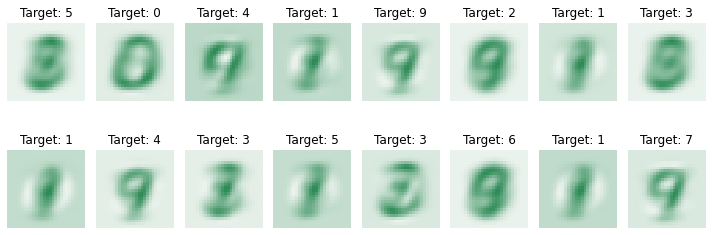

In [141]:
pca = PCA()
features = 3
pca.fit(X, features, feature_scaling=True)
X_tranf = pca.transform(X)
X_restored = pca.reverse_transform(X_tranf)

rows = 2
columns = 8
fig, axs = plt.subplots(rows,columns, figsize=(10, 4))
indx = 0
for i in range(rows):
    for j in range(columns):
        sample = X_restored[indx]
        axs[i,j].imshow(np.reshape(X_restored[indx], (28,28)), interpolation='nearest', cmap=sns.light_palette("seagreen", as_cmap=True))
        axs[i,j].axis('off')
        axs[i,j].autoscale(False)
        axs[i,j].title.set_text(f'Target: {y[indx]}')
        indx += 1
plt.tight_layout()
print(f'Reduced to {pca.k} Features:')
plt.show()

There is a lot less detail now, and its hard to make out some of the digits at all.

Typically selecting a value by hand is not a good idea, but it can be used to project higher dimensional data down into a lower space that allows us to plot it.

Let’s try plotting our reduced data onto a 3D scatter plot and see what comes out.  There is a lot of data so to keep things clear, we'll just use the classes 0, 2, and 8.

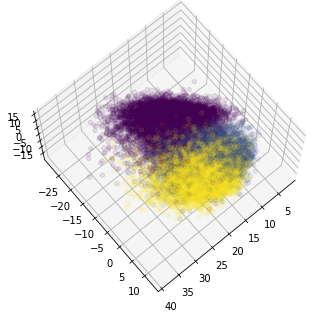

In [82]:
fig = plt.figure()
ax = Axes3D(fig)

le = Utils.Label_Encoder()
y_le = le.fit_transform(y)

filt = np.isin(y,['0','2','8'])
x_axis = X_tranf[filt,0]
y_axis = X_tranf[filt,1]
z_axis = X_tranf[filt,2]
color = y_le[filt]
ax.view_init(70,50)

ax.scatter(x_axis, y_axis, z_axis, c = color, alpha=0.1)
plt.show()

Each point represents a sample in the data, the color is set by the class from y.  Interestingly, the 0's, 2's, and 8's cluster with themselves.  while the recovered images are not very easy to read, clearly there is a relationship being retained in the data even after reducing the features!

What if we don’t need to plot the data, and just want to reduce detentions to reduce complexity and training times?  As mentioned before, selecting a value of features by hand is not usually a good idea.  Instead, we can select an amount of variance to retain.  The more variance the closer to the original data we'll get to when we recover the data.

Let’s try keeping 90% of the variance and see how many features we get.

Reduced to 64 Features:


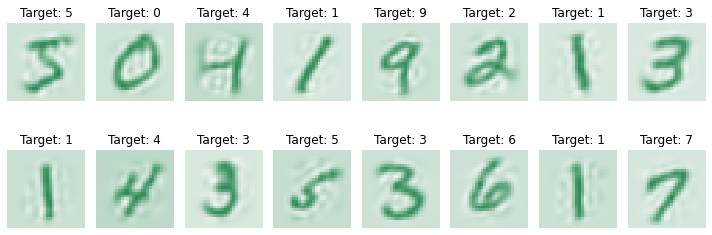

In [142]:
pca = PCA()
variance = 0.90 
pca.fit(X, variance, feature_scaling=True)
X_tranf = pca.transform(X)
X_restored = pca.reverse_transform(X_tranf)

rows = 2
columns = 8
fig, axs = plt.subplots(rows,columns, figsize=(10, 4))
indx = 0
for i in range(rows):
    for j in range(columns):
        sample = X_restored[indx]
        axs[i,j].imshow(np.reshape(X_restored[indx], (28,28)), interpolation='nearest', cmap=sns.light_palette("seagreen", as_cmap=True))
        axs[i,j].axis('off')
        axs[i,j].autoscale(False)
        axs[i,j].title.set_text(f'Target: {y[indx]}')
        indx += 1
plt.tight_layout()
print(f'Reduced to {pca.k} Features:')
plt.show()

Amazing, we can keep 90% of the original data, while reducing the data size by over a factor of 10!  There is some loss in image quality, but nothing that prevents us from clearly reading the numbers.  This amount of compression will greatly improve our training time as there will be far fewer numbers for the computer to calculate!

## PCA Performance Increase

Before we get into clustering, let’s quantify what PCA can do for us.  We will test the time it takes to run one iteration for the feature reduced data versus the original data.

In both cases we will scale X to help with the gradient.  We will train a K-Means model in this example.  Explanation of K-Means is to follow.

In [161]:
scaler = Utils.Scaler()
pca = PCA()
x_scaled = scaler.fit_transform(X)
x_reduced = pca.fit_transform(x_scaled, features=.9)
start = time.time()
km = K_Means()
km.fit(x_scaled, 25, epochs=1, batch_size = 1000)
without_pca = time.time() - start

start = time.time()
km = K_Means()
km.fit(x_reduced, 25, epochs=1, batch_size = 1000)
with_pca = time.time() - start

print(f'One Epoch with PCA (90%): {with_pca:.2f} Seconds\nOne Epoch without PCA : {without_pca:.2f} Seconds\n{without_pca/with_pca:.0%} Performance Increase with PCA!')


One Epoch with PCA (90%): 2.50 Seconds
One Epoch without PCA : 40.78 Seconds
1634% Performance Increase with PCA!


We may not get the absolute best results using the scaled data, but we will be able to train on more itterations faster which could help us if we have a very large dataset.

### Caution:

PCA is not automatic feature selection!  It combines your features based off the variance they provide in the data.  If there are irrelevant features, then PCA will still retain them, and worse make them inseparable from good features.

PCA also does not help with overfitting.  Typically, having more features can lead to over fitting, and PCA removes features, right?   Wrong! PCA does not remove features, it just compresses them into a smaller vector space.  While some of the data loss may help models generalize a little bit, this is a very small side effect and should not be used as a general means of reducing over fitting.  Far better methods exist.

# K-Means

K-Means is a unsupervised learning model that will attempt to group similar items in terms of their Euclidian distance of their vectors to each other.

Unsupervised learning is typically used when you don’t have labeled data.  Let’s try clustering the numbers from MNIST and see if we can create defined groups. Remember that the model doesn’t know the y values, so the cluster labels will not actually correspond to the labels.  Interpreting the clustered data is still up to a human.

# Parameter Selection

Typically with K means there are metrics you can use to determine the best value of K.  Unfortunatly this functionality is not yet implemented in this library today.  In normal practice you can use techniques such as distorition/inertia elbows or silhouette coefficient analysis.

Because that functionality is not availible, we'll use some reasoning to pick a value for K.

- We know that there are 10 classes in the data (0-9) so we will choose a value of at least 10
- Because not every digit is written the same way, its typically a good idea to set K to a higher value than the number of known classes.  Some peoples 4's may look more similar to other peoples 9's then they do other 4's for example.

We'll pick 25 classes.

In [159]:
km = K_Means()
pca = PCA()
scaler = Utils.Scaler()

X_reduced = pca.fit_transform(X, .9, feature_scaling=True)
X_reduced = scaler.fit_transform(X_reduced)

km.fit(X_reduced, 25, epochs=5, batch_size = 1000)
pred = km.predict(X_reduced)

5 epochs only took 17 seconds to run with PCA feature reduction.  If we did not reduce the data it would have taken close to 5 minutes!

Lets see the results:

In [147]:
for i in range(6):
    filt = pred == i
    actuals = y[filt]
    actuals = actuals[:10]
    print(f'Centroid {i}: {actuals}')
print('...')

Centroid 0: ['2' '2' '2' '2' '2' '2' '2' '2' '2' '2']
Centroid 1: ['3' '3' '3' '3' '3' '3' '3' '3' '3' '3']
Centroid 2: ['6' '1' '3' '8' '9' '5' '1' '2' '8' '5']
Centroid 3: ['3' '3' '3' '9' '3' '3' '3' '5' '3' '5']
Centroid 4: ['7' '9' '7' '7' '7' '7' '7' '7' '7' '7']
Centroid 5: ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1']
...


Clustering seems to have worked fairly well!
- Centroid 0: 2's
- Centroid 1: 3's
- Centroid 2: Somewhat mixed, likely on the boundry
- Centroid 3: Mostly 3's
- Centroid 4: Mostly 7's
- Centroid 5: 1's

Remember that the model has never seen the labels, so this is pretty good for training something blind!

*Note: K-Means is non-deterministic, meaning if you run this workflow again, you likely will end up with different results.*